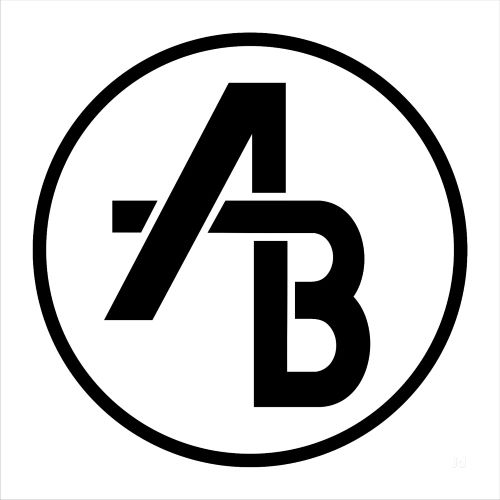

## Project Overview ##

The project aims to use Spark in Python to do data analysis. The project is made up of three parts: a colab notebook, a slide deck and a summary document. The links to the other files are given below:
1. [Slide Deck](https://docs.google.com/presentation/d/1YCFnE6CBtYIv14-eQeic3oZMEtQUjmwxhMuJ-_3GlXQ/edit?usp=sharing)
2. [Summary Document](https://docs.google.com/document/d/1P6sSm7NbcF8hRXZCNz0Ebe8le_RyXDN-nuqDSTERl-o/edit?usp=sharing)


## Initial Spark Set Up - Downloading, Installing and Set Up##
We begin with downloading java and spark and installing them.

Next, in python, we set the java and spark home directories, so that pyspark knows where to find them

Finally, we import the required python libraries for spark and set up a spark session

In [ ]:
# Download and install java and spark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget http://apache.osuosl.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# check here for current versions http://apache.osuosl.org/spark

!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sources [1,863 kB]
Hit:14 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Get:1

In [ ]:
# Set home environments
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
# Set up the spark session

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

## Dataset Download and Clean Up ##
The dataset we will work with is the Online Shoppers Purchasing Intention Dataset. The dataset was formed so that each session
would belong to a different user in a 1-year period to avoid
any tendency to a specific campaign, special day, user
profile, or period.

The main aim is to see if we can predict if the shopper will make a purchase or not.

We start by dowloading the dataset directly from the archives of UCI, in the form of a csv file. We then load this file into spark, thereby creating an RDD object.

Since the data is fed into spark as a text file, each line is a string of comma separated values. These strings need to be transformed into a list of numbers, so that we can analyze them.

Additionally, there are certain categorical features, which are non-numeric. We need to map them to numbers, so that they can be fed into machine learning algorithms. 



In [ ]:
# Download the data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv

--2020-08-30 16:43:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1072063 (1.0M) [application/x-httpd-php]
Saving to: ‘online_shoppers_intention.csv.1’

online_shoppers_int 100%[===================>]   1.02M  3.50MB/s    in 0.3s    

2020-08-30 16:43:28 (3.50 MB/s) - ‘online_shoppers_intention.csv.1’ saved [1072063/1072063]



In [ ]:
df = sc.textFile(r'online_shoppers_intention.csv')

In [ ]:
from time import strptime

def convert_d_types(data_point):
  '''
  Convert all the numbers in the RDD, which are of type string, to floating points.
  Also converts the categorical variables to integers
  '''
  return_point = []
  for i in data_point:
    try:
      return_point.append(float(i))
    except(ValueError):
      return_point.append(i)  
    
  # Convert months to numbers. June is the only month that is not in the proper 3 letter format, so change it to Jun before
  if return_point[10] == 'June':
    return_point[10] = 'Jun'
  return_point[10] = strptime(return_point[10], '%b').tm_mon

  # Three types of visitors. Convert to numbers
  visitors = ['New_Visitor', 'Returning_Visitor', 'Other']
  return_point[15] = visitors.index(return_point[15])

  # Convert weekend, the second last item, to binary (currently True or False)
  if return_point[-2] == 'FALSE':
    return_point[-2] = 0
  else:
    return_point[-2] = 1

  # Convert the label, that is shopped or not, to binary
  if return_point[-1] == 'FALSE':
    return_point[-1] = 0
  else:
    return_point[-1] = 1
  
  return return_point 

In [ ]:
# Preprocessing. Split the strings by commas to create a list. Remove the headers, i.e. the first line. 
# Then run the convert_d_types function to create and rdd that can be inputted into ML models. 
df = df.map(lambda x: x.split(','))

# Remove the headers from the dataset
headers = df.take(1)
df = df.filter(lambda x: x!= headers[0])
df = df.map(convert_d_types)

## Basic Analysis and Statistics (EDA) ##

Simple analysis of the data, to find trends in the conversion rates of shoppers. To make these analysis, we have read the original csv file as a spark dataframe (instead of an RDD like earlier), which makes it easier to do statistical analysis.

The data consists of 18 features, of which 8 are categorical, including the target label. 'Revenue' is the target we are trying to predict. A revenue value of 1 means that the transaction was completed, while a value of 0 means that the transaction was not completed. 

In [ ]:
# A list of categorical features. The keys are the column numbers of the different categorical features part of the data.
# This mapping will be used in latter machine learning algorithms as well.
categorical_feature_count = {10:13, 11:9, 12:14, 13:10, 14:21, 15:3, 16:2}

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType 
from pyspark.sql.functions import col

In [ ]:
# Read the file as a dataframe
pandas_df = spark.read.csv(r'online_shoppers_intention.csv', header=True, inferSchema=True)

In [ ]:
# Convert the two boolean columns into integers, 1 if True, 0 if False
def map_true(line):
  if line==True:
    return 1 
  else:
    return 0

map_true_udf = udf(map_true, returnType='int')
pandas_df = pandas_df.withColumn('Revenue', map_true_udf('Revenue'))
pandas_df = pandas_df.withColumn('Weekend', map_true_udf('Weekend'))

In [ ]:
# Add visit duration and total pages visited
pandas_df = pandas_df.withColumn('Visit_Duration', col('Administrative_Duration')+col('Informational_Duration')+ col('ProductRelated_Duration'))
pandas_df = pandas_df.withColumn('Pages_Visited', col('Administrative')+col('Informational')+ col('ProductRelated'))

In [ ]:
# Conversion rate on special days vs those on regular days
pandas_df.groupby('SpecialDay').mean().select('SpecialDay', 'avg(Revenue)').collect()

[Row(SpecialDay=0.0, avg(Revenue)=0.16526762343171766),
 Row(SpecialDay=0.2, avg(Revenue)=0.07865168539325842),
 Row(SpecialDay=1.0, avg(Revenue)=0.06493506493506493),
 Row(SpecialDay=0.6, avg(Revenue)=0.08262108262108261),
 Row(SpecialDay=0.8, avg(Revenue)=0.033846153846153845),
 Row(SpecialDay=0.4, avg(Revenue)=0.053497942386831275)]

In [ ]:
# Product visits per special day
pandas_df.groupBy('SpecialDay').mean().select('SpecialDay', 'avg(ProductRelated)').collect()

[Row(SpecialDay=0.0, avg(ProductRelated)=32.22348587417637),
 Row(SpecialDay=0.2, avg(ProductRelated)=24.780898876404493),
 Row(SpecialDay=1.0, avg(ProductRelated)=34.83766233766234),
 Row(SpecialDay=0.6, avg(ProductRelated)=24.555555555555557),
 Row(SpecialDay=0.8, avg(ProductRelated)=28.166153846153847),
 Row(SpecialDay=0.4, avg(ProductRelated)=27.555555555555557)]

In [ ]:
# Crosstab of revenue and special days
pandas_df.crosstab('SpecialDay', 'Revenue').collect()

[Row(SpecialDay_Revenue='0.0', 0=9248, 1=1831),
 Row(SpecialDay_Revenue='0.6', 0=322, 1=29),
 Row(SpecialDay_Revenue='1.0', 0=144, 1=10),
 Row(SpecialDay_Revenue='0.2', 0=164, 1=14),
 Row(SpecialDay_Revenue='0.4', 0=230, 1=13),
 Row(SpecialDay_Revenue='0.8', 0=314, 1=11)]

In [ ]:
# Time spent on webpages, grouped by revenue
pandas_df.groupby('Revenue').mean().select('Revenue', 'avg(Administrative_Duration)', 'avg(Informational_Duration)', 'avg(ProductRelated_Duration)').collect()

[Row(Revenue=1, avg(Administrative_Duration)=119.4832438943118, avg(Informational_Duration)=57.61142665093659, avg(ProductRelated_Duration)=1876.2096148889023),
 Row(Revenue=0, avg(Administrative_Duration)=73.74011116864952, avg(Informational_Duration)=30.23623722882732, avg(ProductRelated_Duration)=1069.987809154446)]

In [ ]:
# Conversion rates on weekdays vs weekends
pandas_df.groupby('Weekend').mean().select('Weekend', 'avg(Revenue)').collect()

[Row(Weekend=1, avg(Revenue)=0.17398884239888424),
 Row(Weekend=0, avg(Revenue)=0.1489114352145424)]

In [ ]:
# Duration of sessions on weekdays vs weekends
pandas_df.groupby('Weekend').mean().select('Weekend', 'avg(Visit_Duration)').collect()

[Row(Weekend=1, avg(Visit_Duration)=1346.4157539279045),
 Row(Weekend=0, avg(Visit_Duration)=1299.0106366887844)]

In [ ]:
# Cross tab of day type and revenue count
pandas_df.crosstab('Weekend', 'Revenue').collect()

[Row(Weekend_Revenue='1', 0=2369, 1=499),
 Row(Weekend_Revenue='0', 0=8053, 1=1409)]

In [ ]:
# Summary of page value. Notice how 75% of sessions have 0 page value.
pandas_df.select('PageValues').summary().collect()

[Row(summary='count', PageValues='12330'),
 Row(summary='mean', PageValues='5.889257862693596'),
 Row(summary='stddev', PageValues='18.5684366078065'),
 Row(summary='min', PageValues='0.0'),
 Row(summary='25%', PageValues='0.0'),
 Row(summary='50%', PageValues='0.0'),
 Row(summary='75%', PageValues='0.0'),
 Row(summary='max', PageValues='361.7637419')]

In [ ]:
# Conversion rates per visitor type
pandas_df.groupby('VisitorType').agg({'Revenue': 'mean' , 'VisitorType': 'count'}).collect() 

[Row(VisitorType='New_Visitor', avg(Revenue)=0.24911452184179456, count(VisitorType)=1694),
 Row(VisitorType='Other', avg(Revenue)=0.18823529411764706, count(VisitorType)=85),
 Row(VisitorType='Returning_Visitor', avg(Revenue)=0.1393232868922377, count(VisitorType)=10551)]

In [ ]:
# Crosstab of visitor type and revenue
pandas_df.crosstab('VisitorType', 'Revenue').collect()

[Row(VisitorType_Revenue='Returning_Visitor', 0=9081, 1=1470),
 Row(VisitorType_Revenue='Other', 0=69, 1=16),
 Row(VisitorType_Revenue='New_Visitor', 0=1272, 1=422)]

In [ ]:
# Conversion per month
pandas_df.groupby('Month').mean().select('Month', 'avg(Revenue)').collect()

[Row(Month='Oct', avg(Revenue)=0.20947176684881602),
 Row(Month='Sep', avg(Revenue)=0.19196428571428573),
 Row(Month='Dec', avg(Revenue)=0.1250723798494499),
 Row(Month='Aug', avg(Revenue)=0.17551963048498845),
 Row(Month='May', avg(Revenue)=0.10850178359096314),
 Row(Month='June', avg(Revenue)=0.10069444444444445),
 Row(Month='Feb', avg(Revenue)=0.016304347826086956),
 Row(Month='Nov', avg(Revenue)=0.25350233488992663),
 Row(Month='Mar', avg(Revenue)=0.10068169900367069),
 Row(Month='Jul', avg(Revenue)=0.1527777777777778)]

In [ ]:
# Crosstab of revenue counts per month 
pandas_df.crosstab('Month', 'Revenue').collect()

[Row(Month_Revenue='Nov', 0=2238, 1=760),
 Row(Month_Revenue='Jul', 0=366, 1=66),
 Row(Month_Revenue='Mar', 0=1715, 1=192),
 Row(Month_Revenue='Oct', 0=434, 1=115),
 Row(Month_Revenue='Dec', 0=1511, 1=216),
 Row(Month_Revenue='Feb', 0=181, 1=3),
 Row(Month_Revenue='June', 0=259, 1=29),
 Row(Month_Revenue='May', 0=2999, 1=365),
 Row(Month_Revenue='Aug', 0=357, 1=76),
 Row(Month_Revenue='Sep', 0=362, 1=86)]

In [ ]:
# The conversion rate if page value is over $0.03
pandas_df.filter(pandas_df['PageValues']>0.03).select('Revenue').agg({'Revenue':'mean'}).collect()

[Row(avg(Revenue)=0.5633699633699634)]

In [ ]:
# The conversion rate if page value is under $0.03
pandas_df.filter(pandas_df['PageValues']<0.03).select('Revenue').agg({'Revenue':'mean'}).collect()

[Row(avg(Revenue)=0.03854166666666667)]

In [ ]:
# The overall conversion rate
pandas_df.agg({'Revenue':'mean'}).collect()

[Row(avg(Revenue)=0.15474452554744525)]

In [ ]:
# Conversion rate if bounce rate is over 0.5%
pandas_df.filter(pandas_df['BounceRates']>0.005).select('Revenue').agg({'Revenue':'mean'}).collect()

[Row(avg(Revenue)=0.10081008100810081)]

In [ ]:
pandas_df.filter(pandas_df['BounceRates']>0.005).count(), pandas_df.filter(pandas_df['BounceRates']<0.005).count()

(5555, 6744)

In [ ]:
# Number of sessions where the average page value was 0, compared to the sessions where the page value was positive.
pandas_df.filter(pandas_df['PageValues']==0).count(), pandas_df.filter(pandas_df['PageValues']!=0).count()

(9600, 2730)

In [ ]:
# High correlation between bounce rates and exit rates. To be expected
pandas_df.corr('BounceRates', 'ExitRates'), pandas_df.corr('PageValues', 'ExitRates')

(0.9130043961815185, -0.1744983100017818)

In [ ]:
# Visitor types per region. To find out where the new visitors are coming from
pandas_df.crosstab('Region', 'VisitorType').collect()

[Row(Region_VisitorType='5', New_Visitor=50, Other=0, Returning_Visitor=268),
 Row(Region_VisitorType='1', New_Visitor=657, Other=8, Returning_Visitor=4115),
 Row(Region_VisitorType='6', New_Visitor=121, Other=1, Returning_Visitor=683),
 Row(Region_VisitorType='9', New_Visitor=92, Other=55, Returning_Visitor=364),
 Row(Region_VisitorType='2', New_Visitor=149, Other=5, Returning_Visitor=982),
 Row(Region_VisitorType='7', New_Visitor=100, Other=2, Returning_Visitor=659),
 Row(Region_VisitorType='3', New_Visitor=312, Other=8, Returning_Visitor=2083),
 Row(Region_VisitorType='8', New_Visitor=74, Other=1, Returning_Visitor=359),
 Row(Region_VisitorType='4', New_Visitor=139, Other=5, Returning_Visitor=1038)]

In [ ]:
# Revenue count per region.
pandas_df.crosstab('Region', 'Revenue').collect()

[Row(Region_Revenue='5', 0=266, 1=52),
 Row(Region_Revenue='1', 0=4009, 1=771),
 Row(Region_Revenue='6', 0=693, 1=112),
 Row(Region_Revenue='9', 0=425, 1=86),
 Row(Region_Revenue='2', 0=948, 1=188),
 Row(Region_Revenue='7', 0=642, 1=119),
 Row(Region_Revenue='3', 0=2054, 1=349),
 Row(Region_Revenue='8', 0=378, 1=56),
 Row(Region_Revenue='4', 0=1007, 1=175)]

## Machine Learning ##

The task is to predict if the user will make the purchase or not. The revenue column, which is either a 0 (for no purchase) or a 1 (for purchase) needs to be predicted. Since it is a classification problem, the algorithms that have been used are:
1. Logistic Regression
2. Gradient Boosted Classifiers
3. Random Forests Classifiers
4. Decision Tree Classifiers

Logistic regression and decision trees have also been used to do factor analysis, i.e to find out which features have the most impact on the label. 

The dataset has been broken into a training set and a validation set, to check the model's performance on real-world data. Metrics such as mean accuracy score, confusion matrix, f1 score, precision and recall have been used to  analyze the different models. 

In [ ]:
from pyspark.mllib import classification
from pyspark.mllib.evaluation import BinaryClassificationMetrics  
from pyspark.mllib.tree import DecisionTree, RandomForest, GradientBoostedTrees
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from time import time

In [ ]:
# Create a dataframe of labeled points. All models in the mllib only work with labeled points
def make_labeled_point(line):
  label = classification.LabeledPoint(label=line[-1], features=line[:-1])
  return label

labeled_df = df.map(make_labeled_point)

In [ ]:
# Divide the data into 2 sets, training and validation. Keep the seed, for the same results in future runs
train, test= labeled_df.randomSplit([0.75, 0.25], seed=1123581321)

In [ ]:
train.count(), test.count()

(9234, 3096)

#### Logistic Regression ####

In [ ]:
# Train a logisitc regression model.
st = time()
logit_mod = classification.LogisticRegressionWithLBFGS.train(train)
print(time()-st)

4.354787349700928


In [ ]:
# The coefficients of different features in the logistic regression model. The higher the coefficient, the more its impact on the probability of prediction
logit_coefficients = logit_mod.weights.toArray()
list(zip(headers[0], logit_coefficients))

[('Administrative', -0.0178697578167729),
 ('Administrative_Duration', -0.00042560065137684785),
 ('Informational', 0.03708265537997858),
 ('Informational_Duration', -9.47781879783546e-05),
 ('ProductRelated', 0.003206048822664305),
 ('ProductRelated_Duration', 6.109875491016479e-05),
 ('BounceRates', 6.000323424952377),
 ('ExitRates', -25.804856143354428),
 ('PageValues', 0.08294190726118117),
 ('SpecialDay', -1.0077493842454353),
 ('Month', 0.003856706813243217),
 ('OperatingSystems', -0.3982220381826083),
 ('Browser', -0.020843356752525306),
 ('Region', -0.06136595942461619),
 ('TrafficType', -0.0074890970925662525),
 ('VisitorType', -0.7695006432099138),
 ('Weekend', -0.08327922194903638)]

In [ ]:
# Make predictions on the features of the test dataset, and join the results with the correct labels  
predictions = logit_mod.predict(test.map(lambda x: x.features)).map(lambda x: float(x))
labels_and_predictions = predictions.zip(test.map(lambda x: x.label))

In [ ]:
# Metrics for the predictions 
metrics = MulticlassMetrics(labels_and_predictions)

In [ ]:
metrics.confusionMatrix().toArray()

array([[2550.,   72.],
       [ 291.,  183.]])

In [ ]:
metrics.fMeasure(0.0, 1.0), metrics.precision(0), metrics.recall(0)

(0.9335529928610653, 0.8975712777191129, 0.9725400457665904)

In [ ]:
metrics.accuracy

0.8827519379844961

#### Support Vector Machines ####

In [ ]:
svm = classification.SVMWithSGD.train(train)
predictions_svm = svm.predict(test.map(lambda x: x.features)).map(lambda x: float(x))

In [ ]:
labels_and_predictions_svm = predictions_svm.zip(test.map(lambda x: x.label))

In [ ]:
metrics_svm = MulticlassMetrics(labels_and_predictions_svm)
metrics_svm.confusionMatrix().toArray()

array([[2.621e+03, 1.000e+00],
       [4.730e+02, 1.000e+00]])

#### Gradient Boosted Machines ####

In [ ]:
st = time()
gbm = GradientBoostedTrees.trainClassifier(train, categoricalFeaturesInfo=categorical_feature_count, learningRate=0.05, numIterations=200, maxDepth=4)
print(time()-st)

75.34230589866638


In [ ]:
preds_gbm = gbm.predict(test.map(lambda x: x.features)).map(lambda x: float(x))
labels_and_predictions_gbm = preds_gbm.zip(test.map(lambda x: x.label))

In [ ]:
metrics_gbm = MulticlassMetrics(labels_and_predictions_gbm)

In [ ]:
metrics_gbm.confusionMatrix().toArray()

array([[2505.,  117.],
       [ 167.,  307.]])

In [ ]:
metrics_gbm.accuracy, metrics_gbm.precision(0), metrics_gbm.recall(0)

(0.9082687338501292, 0.9375, 0.9553775743707094)

#### Random Forest Classifier ####

In [ ]:
st = time()
rf = RandomForest.trainClassifier(train, numClasses=2, categoricalFeaturesInfo=categorical_feature_count, maxDepth=30, numTrees=300, seed=1123581321)
print(time()-st)

326.14335441589355


In [ ]:
preds_rf = rf.predict(test.map(lambda x: x.features)).map(lambda x: float(x))

In [ ]:
labels_and_predictions_rf = preds_rf.zip(test.map(lambda x: x.label))

In [ ]:
metrics_rf = MulticlassMetrics(labels_and_predictions_rf)

In [ ]:
metrics_rf.confusionMatrix().toArray()

array([[2500.,  122.],
       [ 172.,  302.]])

In [ ]:
metrics_rf.precision(0.0), metrics_rf.recall(0.0), metrics_rf.accuracy

(0.9356287425149701, 0.9534706331045004, 0.9050387596899225)

#### Decision Tree Classifier ####

In [ ]:
st = time()
dec_tree = DecisionTree().trainClassifier(train, numClasses=2, categoricalFeaturesInfo=categorical_feature_count, maxDepth=3)
print(time()-st)

1.7235162258148193


In [ ]:
preds_dec_tree = dec_tree.predict(test.map(lambda x: x.features))

In [ ]:
labels_and_predictions_dt = preds_dec_tree.zip(test.map(lambda x: x.label))

In [ ]:
metrics_dt = MulticlassMetrics(labels_and_predictions_dt)

In [ ]:
metrics_dt.confusionMatrix().toArray()

array([[2491.,  131.],
       [ 175.,  299.]])

In [ ]:
metrics_dt.accuracy, metrics_dt.recall(0), metrics_dt.precision(0)

(0.9011627906976745, 0.9500381388253242, 0.9343585896474118)

In [ ]:
# To get the structure of the tree 
dec_tree.toDebugString()

'DecisionTreeModel classifier of depth 3 with 7 nodes\n  If (feature 8 <= 0.033524773)\n   Predict: 0.0\n  Else (feature 8 > 0.033524773)\n   If (feature 6 <= 8.075E-5)\n    Predict: 1.0\n   Else (feature 6 > 8.075E-5)\n    If (feature 10 in {5.0,10.0,6.0,9.0,2.0,12.0,7.0,3.0,8.0})\n     Predict: 0.0\n    Else (feature 10 not in {5.0,10.0,6.0,9.0,2.0,12.0,7.0,3.0,8.0})\n     Predict: 1.0\n'